In [5]:
import sys
sys.path.append("/shareb/zliu/analysis/")



from matplotlib import pyplot as plt
import numpy as np
import pandas as pd



import glob
import re



import cooler
from scipy import stats

from CHARMtools import Cell3D
import imp
imp.reload(Cell3D)
from CHARMtools import imputation
imp.reload(imputation)


ModuleNotFoundError: No module named 'rmsd'

In [3]:
import rmsd

ModuleNotFoundError: No module named 'rmsd'

In [4]:
def compute_pearson(matrix1,matrix2):
    flatten_matrix_1 = matrix1.flatten()
    flatten_matrix_2 = matrix2.flatten()

    # Replace inf values with nan
    flatten_matrix_1 = np.where(np.isinf(flatten_matrix_1), np.nan, flatten_matrix_1)
    flatten_matrix_2 = np.where(np.isinf(flatten_matrix_2), np.nan, flatten_matrix_2
    # Remove any NaN values from both arrays (only where both have NaNs in the same position)
    mask = ~np.isnan(flatten_matrix_1) & ~np.isnan(flatten_matrix_2)
    flatten_matrix_1 = flatten_matrix_1[mask]
    flatten_matrix_2 = flatten_matrix_2[mask]

    # Check if there are any remaining NaNs or infs
    if not np.isfinite(flatten_matrix_1).all() or not np.isfinite(flatten_matrix_2).all():
        raise ValueError("The input arrays contain infs or NaNs after preprocessing.")

    # Now you can safely call pearsonr
    pearsonr_value,_ = stats.pearsonr(flatten_matrix_1, flatten_matrix_2)

    return pearsonr_value

def compute_pearson(matrix1,matrix2):
    flatten_matrix_1 = matrix1.flatten()
    flatten_matrix_2 = matrix2.flatten()

    # Replace inf values with nan
    flatten_matrix_1 = np.where(np.isinf(flatten_matrix_1), np.nan, flatten_matrix_1)
    flatten_matrix_2 = np.where(np.isinf(flatten_matrix_2), np.nan, flatten_matrix_2)

    # Remove any NaN values from both arrays (only where both have NaNs in the same position)
    mask = ~np.isnan(flatten_matrix_1) & ~np.isnan(flatten_matrix_2)
    flatten_matrix_1 = flatten_matrix_1[mask]
    flatten_matrix_2 = flatten_matrix_2[mask]

    # Check if there are any remaining NaNs or infs
    if not np.isfinite(flatten_matrix_1).all() or not np.isfinite(flatten_matrix_2).all():
        raise ValueError("The input arrays contain infs or NaNs after preprocessing.")

    spearmanr_value,_ = stats.spearmanr(distance_matrix_1, distance_matrix_2)

    return spearmanr_value

def compute_ssmi(matrix1,matrix2):
    ssmis = ssim((matrix1 - matrix1.mean()) / matrix1.std(), (matrix2 - matrix2.mean()) / matrix2.std())
    return ssmis

def compute_mse(matrix1,matrix2):
    mse = mean_squared_error((matrix1 - matrix1.mean()) / matrix1.std(), (matrix2 - matrix2.mean()) / matrix2.std())
    return mse

    

In [8]:
#mkdir -p dipc3dg; ls downsample_simple_pairs_dipc/ | sed -e "s/.pairs.gz//g"  |\
# parallel -j 200 --progress "~/biosoft/hickit-0.1.1_x64-linux/hickit -P1 -M  -s1 |\
# -i downsample_simple_pairs_dipc/{}.pairs.gz -Sr1m -c1 -r10m -c2 -b5m -b1m -O |\ 
# dipc3dg/{}.1m.1.3dg -b200k -O dipc3dg/{}.200k.1.3dg  -D5 -b50k -O dipc3dg/{}.50k.1.3dg"

In [9]:
cellnames = [re.split("/",i)[4].replace(".pairs.gz","") for i in glob.glob("/shareb/zliu/analysis/imputation/Data/su2020/downsample_simple_pairs_dipc/*")]

In [8]:
cell = Cell3D.Cell3D(cellname = cellnames[0],tdg_path = "/shareb/zliu/analysis/imputation/Data/su2020/dipc3dg/" + 'chr2_copy1001_sample_500contacts_fraction3' + ".200k.1.3dg",resolution=200000)
cell.add_chrom_length("/share/Data/public/ref_genome/human_ref/GRCh37d5/raw_data/hg19.chr.len")

In [3]:
chrom = 2
chrom_path = f"/shareb/mliu/evaluate_impute/image_analysis/data/chromosome{chrom}.tsv"
df_all = pd.read_csv(chrom_path,sep="\t")

df_all['chrom'] = df_all['Genomic coordinate'].apply(lambda x: x.split(":")[0])
df_all['start'] = df_all['Genomic coordinate'].apply(lambda x: x.split(":")[1].split("-")[0]).astype(int)
df_all['end'] = df_all['Genomic coordinate'].apply(lambda x: x.split(":")[1].split("-")[1]).astype(int)
df_all['pos'] = ((df_all['start'] + df_all['end']) / 2).astype(int)

df_all = df_all[['chrom','pos','X(nm)','Y(nm)','Z(nm)','Chromosome copy number']]
df_all.columns = ['chrom','pos','x','y','z','copy_id']
df_all['copy_id'] = df_all['copy_id'].astype(int)

In [4]:
copy_id = 1001
copy_id = copy_id+1 # 0 based to 1 based
resolution = 200000

df_cell = df_all.query('copy_id == @copy_id').copy()
df_cell["pos"] = ((df_cell["pos"] + resolution/2) // resolution * resolution).astype(int)
df_cell = df_cell[["chrom","pos","x","y","z"]]
df_cell = df_cell.query('pos>0').groupby(["chrom", "pos"])[['x', 'y', 'z']].mean().reset_index()

In [9]:
cell_imaging = Cell3D.Cell3D(cellname = "copy1001",tdg_path = df_cell,resolution=200000)
cell_imaging.add_chrom_length("/share/Data/public/ref_genome/human_ref/GRCh37d5/raw_data/hg19.chr.len")

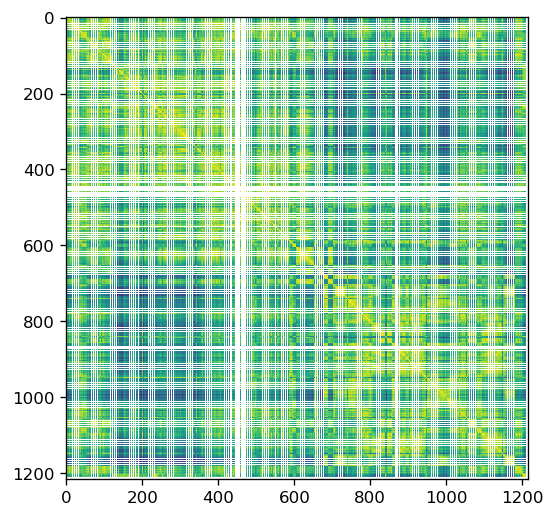

In [10]:
# plot matrix
fig = plt.figure(figsize=(5, 5),dpi=120)
plt.imshow(cell_imaging.calc_distance_matrix("chr2"), cmap='viridis_r', interpolation='nearest')

In [12]:
def mat_cor_with_na(mat1,mat2):
    # Calculate distance matrices
    distance_matrix_1 = mat1.flatten()
    distance_matrix_2 = mat2.flatten()

    # Replace inf values with nan
    distance_matrix_1 = np.where(np.isinf(distance_matrix_1), np.nan, distance_matrix_1)
    distance_matrix_2 = np.where(np.isinf(distance_matrix_2), np.nan, distance_matrix_2)

    # Remove any NaN values from both arrays (only where both have NaNs in the same position)
    mask = ~np.isnan(distance_matrix_1) & ~np.isnan(distance_matrix_2)
    distance_matrix_1 = distance_matrix_1[mask]
    distance_matrix_2 = distance_matrix_2[mask]

    # Check if there are any remaining NaNs or infs
    if not np.isfinite(distance_matrix_1).all() or not np.isfinite(distance_matrix_2).all():
        raise ValueError("The input arrays contain infs or NaNs after preprocessing.")

    # Now you can safely call pearsonr
    pearsonr_value,_ = stats.pearsonr(distance_matrix_1, distance_matrix_2)
    spearmanr_value,_ = stats.spearmanr(distance_matrix_1, distance_matrix_2)

    return [pearsonr_value,spearmanr_value]

In [13]:
import tqdm

structure_corr = []
schiclsuter_corr = []
resolution = 200000

for i in tqdm.tqdm(range(50)):
    cell = Cell3D.Cell3D(cellname = "test",tdg_path = "./Data/su2020/dipc3dg/" + 'chr2_copy' + str(i) + '_sample_500contacts_fraction3' + ".200k.1.3dg",resolution=resolution)
    cell.add_chrom_length("/share/Data/public/ref_genome/human_ref/GRCh37d5/raw_data/hg19.chr.len")

    copy_id = i+1
    df_cell = df_all.query('copy_id == @copy_id').copy()
    df_cell["pos"] = ((df_cell["pos"] + resolution/2) // resolution * resolution).astype(int)
    df_cell = df_cell[["chrom","pos","x","y","z"]]
    df_cell = df_cell.query('pos>0').groupby(["chrom", "pos"])[['x', 'y', 'z']].mean().reset_index()

    cell_imaging = Cell3D.Cell3D(cellname = "image_test",tdg_path = df_cell,resolution=resolution)
    cell_imaging.add_chrom_length("/share/Data/public/ref_genome/human_ref/GRCh37d5/raw_data/hg19.chr.len")

    mat = cooler.Cooler("./Data/su2020/mcools/chr2_copy"+str(i)+"_sample_500contacts_fraction3.mcool::/resolutions/200000").matrix(balance=False).fetch("chr2")
    impute_mat = imputation.schicluster_imputation_for_mat(mat,0.5)
    impute_mat = -np.log2(impute_mat)

    structure_corr.append(mat_cor_with_na(cell_imaging.calc_distance_matrix("chr2"),cell.calc_distance_matrix("chr2")))
    schiclsuter_corr.append(mat_cor_with_na(cell_imaging.calc_distance_matrix("chr2"),impute_mat))

    
imp.reload(imputation)

<module 'CHARMtools.imputation' from '/shareb/zliu/analysis/CHARMtools/imputation.py'>

In [18]:
import concurrent.futures
import tqdm
import warnings

def process_iteration(i,resolution=200000):
    try:
        cell = Cell3D.Cell3D(cellname="test", tdg_path="/shareb/zliu/analysis/imputation/Data/su2020/dipc3dg/chr2_copy" + str(i) + "_sample_500contacts_fraction3.200k.1.3dg", resolution=resolution)
        cell.add_chrom_length("/share/Data/public/ref_genome/human_ref/GRCh37d5/raw_data/hg19.chr.len")

        copy_id = i + 1
        df_cell = df_all.query('copy_id == @copy_id').copy()
        df_cell["pos"] = ((df_cell["pos"] + resolution/2) // resolution * resolution).astype(int)
        df_cell = df_cell[["chrom","pos","x","y","z"]]
        df_cell = df_cell.query('pos>0').groupby(["chrom", "pos"])[['x', 'y', 'z']].mean().reset_index()

        #创建
        cell_imaging = Cell3D.Cell3D(cellname="image_test", tdg_path=df_cell, resolution=resolution)
        cell_imaging.add_chrom_length("/share/Data/public/ref_genome/human_ref/GRCh37d5/raw_data/hg19.chr.len")

        #下采样之后的矩阵
        mat = cooler.Cooler("/shareb/zliu/analysis/imputation/Data/su2020/mcools/chr2_copy"+str(i)+"_sample_500contacts_fraction3.mcool::/resolutions/200000").matrix(balance=False).fetch("chr2")
        impute_mat = imputation.schicluster_imputation_for_mat(mat, 0.5)
        impute_mat = -np.log2(impute_mat)

        #print("check 1")
        ctg_mat = imputation.ctg_impute_v2(mat)
        #print("check 2")

        return (
            mat_cor_with_na(cell_imaging.calc_distance_matrix("chr2"), cell.calc_distance_matrix("chr2")),
            mat_cor_with_na(cell_imaging.calc_distance_matrix("chr2"), impute_mat),
            mat_cor_with_na(cell_imaging.calc_distance_matrix("chr2"), ctg_mat)
        )
    except Exception as e:
        warnings.warn(f"Error in {i}: {e},continue")
        return ([np.nan,np.nan],[np.nan,np.nan],[np.nan,np.nan])

In [19]:
process_iteration(1)

([0.7440393841794763, 0.7752507647445741],
 [0.8152741429239554, 0.8344002711896941],
 [0.17419576398590866, 0.2961225673446518])

In [20]:
structure_corr = []
schiclsuter_corr = []
ctg_corr = []
resolution = 200000

# Use ThreadPoolExecutor or ProcessPoolExecutor based on your task nature
with concurrent.futures.ProcessPoolExecutor(max_workers = 20) as executor:
    futures = [executor.submit(process_iteration, i) for i in range(100)]
    for future in tqdm.tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
        result = future.result()
        structure_corr.append(result[0])
        schiclsuter_corr.append(result[1])
        ctg_corr.append(result[2])


  0%|          | 0/100 [00:12<?, ?it/s]


In [82]:
data = pd.DataFrame(structure_corr,columns=["pearson","spearman"])
data["method"] = "structure"
data2 = pd.DataFrame(schiclsuter_corr,columns=["pearson","spearman"])
data2["method"] = "schicluster"
data3 = pd.DataFrame(ctg_corr,columns=["pearson","spearman"])
data3["method"] = "ctg"
data=pd.concat([data,data2,data3]).dropna()

Ttest_indResult(statistic=-0.9546022438722032, pvalue=0.34094286855559586)
Ttest_indResult(statistic=-1.397055428714316, pvalue=0.1639606223046462)


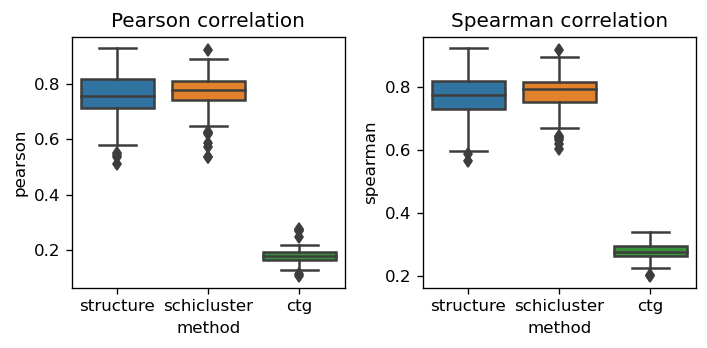

In [83]:
import seaborn as sns
# boxplot of pearson/spearman correlations
fig, ax = plt.subplots(ncols=2,figsize=(6,3),dpi=120)
ax[0].set_title("Pearson correlation")
sns.boxplot(x="method", y="pearson", data=data,ax=ax[0])
ax[1].set_title("Spearman correlation")
sns.boxplot(x="method", y="spearman", data=data,ax=ax[1])

# add t-test
from scipy import stats
print(stats.ttest_ind(data.query('method=="structure"')["pearson"],data.query('method=="schicluster"')["pearson"]))
print(stats.ttest_ind(data.query('method=="structure"')["spearman"],data.query('method=="schicluster"')["spearman"]))

plt.tight_layout()



In [84]:
data = pd.DataFrame(structure_corr,columns=["pearson_structure","spearman_structure"])
#data["method"] = "structure"
data2 = pd.DataFrame(schiclsuter_corr,columns=["pearson_schicluster","spearman_schicluster"])
data3 = pd.DataFrame(ctg_corr,columns=["pearson_ctg","spearman_ctg"])
#data2["method"] = "schicluster"
data=pd.concat([data,data2,data3],axis=1).dropna()

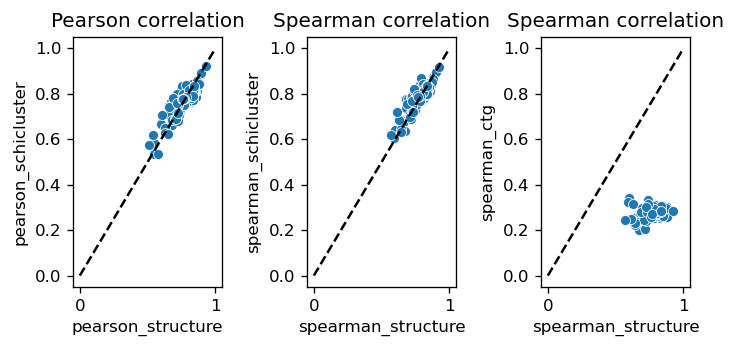

In [85]:
#相关性
fig, ax = plt.subplots(ncols=3,figsize=(6,3),dpi=120)
ax[0].set_title("Pearson correlation")
sns.scatterplot(x="pearson_structure", y="pearson_schicluster", data=data,ax=ax[0])
ax[0].plot([0,1],[0,1],color="black",linestyle="--")
ax[1].set_title("Spearman correlation")
sns.scatterplot(x="spearman_structure", y="spearman_schicluster", data=data,ax=ax[1])
ax[1].plot([0,1],[0,1],color="black",linestyle="--")
ax[2].set_title("Spearman correlation")
sns.scatterplot(x="spearman_structure", y="spearman_ctg", data=data,ax=ax[2])
ax[2].plot([0,1],[0,1],color="black",linestyle="--")

plt.tight_layout()

